In [1]:
import os
os.chdir('/Users/ernestng/Desktop/projects/foodreview/amazon-fine-food-reviews/')
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, recall_score, accuracy_score, roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
import pandas as pd
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.corpus import stopwords
pd.options.display.max_columns = 10
pd.options.mode.chained_assignment = None
import numpy as np
import requests
from functools import reduce
from string import punctuation
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from time import sleep
import re
from collections import Counter


In [2]:
fooddf = pd.read_csv("./Reviews.csv")
fooddf = fooddf[['Score', 'Text']]

Check counts of each rating(1-5)

In [3]:
fooddf.groupby('Score').count()

,Text
Score,
1,52268
2,29769
3,42640
4,80655
5,363122


We see that there is a significantly larger number of reviews with rating of 5, so I plan to use random under sampling to balance the data.

Random Under sampling aims to balance class distribution by randomly eliminating majority class examples. This is done until the majority and minority class instances are balanced out. In this approach, I reduce the data from higher class (data with 4 and 5 rating) to match the data with lower class(data with 1 and 2 rating).

I can eliminate data with 3 rating since I want to create a binary classifer and rating 3 is really sitting on the fence, although we can keep in mind rating 3 might be useful for multiclass classifier

counts of rating 1-2 : 82037
counts of rating 4-5 : 443777 (I will randomly pick 82037 data points from here)

In [4]:
food_low = fooddf[fooddf['Score']<3]
food_low.head()

,Score,Text
1,1,Product arrived labeled as Jumbo Salted Peanut...
3,2,If you are looking for the secret ingredient i...
12,1,My cats have been happily eating Felidae Plati...
16,2,I love eating them and they are good for watch...
26,1,"The candy is just red , No flavor . Just plan..."


In [5]:
food_high = fooddf[fooddf['Score']>3]
food_high.head()
food_high_resampled = food_high.sample(n = 82037, random_state=12)

In [6]:
new_food = pd.concat([food_low,food_high_resampled])
def sentiment(x):
    if x < 3:
        return 0
    else:
        return 1
new_food["sentiment"] = new_food.Score.map(sentiment)
new_food.sentiment.value_counts()

1    82037
0    82037
Name: sentiment, dtype: int64

In [7]:
new_food

,Score,Text,sentiment
1,1,Product arrived labeled as Jumbo Salted Peanut...,0
3,2,If you are looking for the secret ingredient i...,0
12,1,My cats have been happily eating Felidae Plati...,0
16,2,I love eating them and they are good for watch...,0
26,1,"The candy is just red , No flavor . Just plan...",0
...,...,...,...
410093,5,Loved this for breakfast as a child. My child...,1
217854,5,"After a lengthy trek in the Himalayan Range, t...",1
426527,5,These wafers are wonderfully light and taste j...,1
395540,5,I'm a huge fan of Earnest Eats with my favorit...,1


X input : Text
y output : sentiment

In [8]:
X_train, X_test, y_train, y_test = train_test_split(new_food.Text, new_food.sentiment, test_size=0.1, random_state=42)


After splitting the data, I use CountVectorizer() to convert text documents to matrix of token counts. 

This configuration tokenize the strings and convert them to lower case and build a vocabulary of comma separated tokens.

In [9]:
xvect = CountVectorizer().fit(X_train)
xtrain_vect = xvect.transform(X_train)

This data is further processed by applying Tfidf Vectorizer, which helps us to give more weightage to important words which less important words for the case study would be given more weights.
Since, our code is based on counting the frequency of each word in the document, so if certain words like ‘the’, ‘if’ etc. which are present more frequently then words which are more important such as ‘buy’,’product’ etc. , which gives us the context.

In [10]:
xvect = TfidfVectorizer().fit(X_train)
xtrain_vect = xvect.transform(X_train)
len(xvect.get_feature_names())

66953

I further improve my model, for example it would help us to differentiate between ‘good’ and ‘not good’ as it would take both words together(for bi gram count pairs). Also, it would help us to work with more features. I have set the n-grams in the range of 1–2 which helps us to extract features for 1 and 2 grams.

In [11]:
xvect = TfidfVectorizer(ngram_range = (1,3)).fit(X_train)
xtrain_vect = xvect.transform(X_train)
len(xvect.get_feature_names())

6002749

To fit this model, I am going to use Logistic Regression and Multinomial Naive Bayes Algorithm and I will compare both the models.

Multinomial NB

In [12]:
food_model = MultinomialNB()
food_model.fit(xtrain_vect, y_train)


MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [13]:
predictions = food_model.predict(xvect.transform(X_test))
roc_auc_score(y_test, predictions)

0.9350965745754435

Logistic Regression

Parameters I changed: 
1) multi_class='ovr' (Binary problem is fit for each label)
2) n_jobs=1 (Number of CPU cores used when parallelizing over classes if multi_class=’ovr’)
3) solver='liblinear' (Algorithm to use when optimizing over a small dataset such as this)

In [14]:
food_LRmodel = LogisticRegression(n_jobs=1,multi_class='ovr',solver='liblinear')
food_LRmodel.fit(xtrain_vect, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
                   solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

In [15]:
predictionsLR = food_LRmodel.predict(xvect.transform(X_test))
roc_auc_score(y_test, predictionsLR)

0.9358109760522249

Logistic Regression(LR) gives us a better AUC score than Multinomial NB(MNB). 
LR gives better prediction than MNB, hence I will the LR model

Function to determine review input

In [16]:
def predictreview(x):
    rev = food_LRmodel.predict(xvect.transform(x))
    rev_list = np.where(rev==1,"Positive","Negative").tolist()
    return rev_list

Test cases

In [17]:
test = ["the ayam penyet i had today was awesome!",
         "good plate of fried rice, but expensive",
        "portion too small",
        "great value for money!",
        "cheap and good food",
        "cheap food",
        "waste of money",
        "terrible service and the food is badly done",
        "edible but i will not visit again",
       "wonderful service, i will definitely visit again",
       "not very good"]

test_chinese = ["hen haochi", 
                "hen bu haochi", 
                "shiwu bu hao chi",
                "wo bu xi huan shiwu",
                "wo xi huan shiwu"]
predictreview(test)

['Positive',
 'Positive',
 'Negative',
 'Positive',
 'Positive',
 'Negative',
 'Negative',
 'Negative',
 'Negative',
 'Positive',
 'Negative']

I included some hanyupinyin to test if my model can understand chinese words

In [18]:
predictreview(test_chinese)

['Positive', 'Negative', 'Negative', 'Negative', 'Positive']

Confusion matrix looks good, number of true positives and true negatives are quite even 

In [19]:
confusion_matrix(y_test, predictionsLR)

array([[7743,  479],
       [ 574, 7612]])

The recall_score tells us intuitively the ability of the classifier to find all the positive samples.

Conclusion: This model is trained against Amazon Fine Food Dataset with 164074 reviews after cleaning the data. We have achieved an accuracy score of around 93.57% which is quite good. I believe when I train this model against a larger dataset, I can achieve a much higher accuracy.


# Now we will retrieve some reviews about places in Singapore and apply sentiment analysis on them

In [20]:
location_class = "lemon--a__373c0__IEZFH link__373c0__1G70M link-color--inherit__373c0__3dzpk link-size--inherit__373c0__1VFlE"
review_class = 'lemon--p__373c0__3Qnnj text__373c0__2pB8f comment__373c0__3EKjH text-color--normal__373c0__K_MKN text-align--left__373c0__2pnx_'
date_class = 'lemon--span__373c0__3997G text__373c0__2pB8f text-color--mid__373c0__3G312 text-align--left__373c0__2pnx_'
country_class = 'lemon--span__373c0__3997G text__373c0__2pB8f text-color--normal__373c0__K_MKN text-align--left__373c0__2pnx_ text-weight--bold__373c0__3HYJa text-size--small__373c0__3SGMi'

In [21]:
#base_next_url = 'https://www.yelp.com'
location_class="lemon--a__373c0__IEZFH link__373c0__1G70M link-color--inherit__373c0__3dzpk link-size--inherit__373c0__1VFlE"

I define these functions to retrieve all possible locations from the main URL

In [22]:
main_url = 'https://www.yelp.com/search?find_desc=&find_loc=singapore&ns=1'
session = requests.Session()
def getLocs(url):
    #main = 'https://www.yelp.com/search?find_desc=&find_loc=singapore&ns=1'
    request = session.get(url)
    soup = BeautifulSoup(request.content,'html.parser')
    search_results = soup.findAll("a",{"class":location_class})
    loc_urls = []
    for s in search_results:
        
        if s.get_text().isdigit():
            continue
        else:
            loc_urls.append(s['href'])
    return loc_urls

def getPages(url):
    request = session.get(url)
    soup = BeautifulSoup(request.content,'html.parser')
    search_results = soup.findAll("a",{"class":location_class})
    pages_urls = []
    for s in search_results:

        if s.get_text().isdigit():
            pages_urls.append(s['href'])
        else:
            continue
    return pages_urls

def crawlPage(main_url):
    all_loc_urls = []
    r_page_urls = []
    base_url = 'https://www.yelp.com'
    print("Scraping",main_url,"...")
    all_loc_urls += getLocs(main_url)
    r_page_urls += getPages(main_url)
    for page in r_page_urls:
        current = base_url + page
        print("Scraping",current,"...")
        all_loc_urls += getLocs(current)
    n = len(all_loc_urls)
    print("Scraped", n,"possible locations!")
    return all_loc_urls

new_locs = crawlPage(main_url)
#new_locs

Scraping https://www.yelp.com/search?find_desc=&find_loc=singapore&ns=1 ...
Scraping https://www.yelp.com/search?find_loc=singapore&start=10 ...
Scraping https://www.yelp.com/search?find_loc=singapore&start=20 ...
Scraping https://www.yelp.com/search?find_loc=singapore&start=30 ...
Scraping https://www.yelp.com/search?find_loc=singapore&start=40 ...
Scraping https://www.yelp.com/search?find_loc=singapore&start=50 ...
Scraping https://www.yelp.com/search?find_loc=singapore&start=60 ...
Scraping https://www.yelp.com/search?find_loc=singapore&start=70 ...
Scraping https://www.yelp.com/search?find_loc=singapore&start=80 ...
Scraped 90 possible locations!


Here are functions to retrieve information in a single page

In [23]:
def getReviews(url):
    request = session.get(url)
    soup = BeautifulSoup(request.content,'html.parser')
    search_results = soup.findAll("p",{"class":review_class}) #get reviews
    revs = []
    for s in search_results:
        revs.append(s.get_text())
    return revs
    
def getCountries(url):
    request = requests.get(url)
    soup = BeautifulSoup(request.content,'html.parser')
    search_results = soup.findAll("span",{"class":country_class}) #get countries
    ctrs = []
    for s in search_results:
        ctrs.append(s.get_text())
    return ctrs
    
def getDates(url):
    request = requests.get(url)
    soup = BeautifulSoup(request.content,'html.parser')
    search_results = soup.findAll("span",{"class":date_class}) #get dates
    dates = []
    for s in search_results:
        dates.append(s.get_text())
    return dates

This are my functions to clean and tokenize the reviews 

In [24]:
stop_words = []

f = open('/Users/ernestng/Desktop/projects/webscrap/stopwords.txt', 'r')
for l in f.readlines():
    stop_words.append(l.replace('\n', ''))
    
additional_stop_words = ['a','pm','tian','will','sooo']
stop_words += additional_stop_words

def _removeNonAscii(s): 
    return "".join(i for i in s if ord(i)<128)

def clean_text(text):
    text = text.lower()
    text = re.sub(r"what's", "what is ", text)
    text = text.replace('(ap)', '')
    text = re.sub(r"\'s", " is ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"can't", "cannot ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r'\W+', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r"\\", "", text)
    text = re.sub(r"\'", "", text)    
    text = re.sub(r"\"", "", text)
    text = re.sub('[^a-zA-Z ?!]+', '', text)
    text = _removeNonAscii(text)
    text = text.strip()
    return text

def tokenizer(text):
    text = clean_text(text)    
    tokens = [word_tokenize(sent) for sent in sent_tokenize(text)]
    tokens = list(reduce(lambda x,y: x+y, tokens))
    tokens = list(filter(lambda token: token not in (stop_words + list(punctuation)) , tokens))
    return tokens

This function will crawl through each page and retrieve the names of every restaurant, as well as their reviews.

In [25]:
def crawlReviews(loc_lists):
    base_url = 'https://www.yelp.com'
    reviews = []
    #countries = []
    #dates = []
    place_name = []
    #ctr = 0
    for loc in loc_lists:
        current_url = base_url + loc
        pattern = "/biz/(.*?)-singapore"
        placename = re.search(pattern, loc).group(1)
        #print("Getting info on", placename, "...")
        rev = getReviews(current_url)
        n = len(rev)
        reviews += rev
        #countries += getCountries(current_url)
        #dates += getDates(current_url)
        place_name += [placename] * n
        #print("Retrieved", n, "reviews!")
        
    reviews = list(map(clean_text,reviews))
    sentiment = predictreview(reviews)
    print(len(reviews),len(place_name))
    loc_dict = {"Place":place_name, "Reviews": reviews, "Sentiment": sentiment}#,"Countries": countries, "Date": dates
    
    loc_df = pd.DataFrame(data = loc_dict)
    #i import my results into a csv file for easy accessibility in the future
    try:
        loc_df.to_csv('/Users/ernestng/Desktop/projects/foodreview/yelpreviews.csv', encoding='utf-8', index=False)
    except:
        loc_df.to_csv('/Users/ernestng/Desktop/projects/foodreview/yelpreviews.csv', index=False, encoding='utf-8')
    return loc_df

res = crawlReviews(new_locs)
res

1792 1792


,Place,Reviews,Sentiment
0,gardens-by-the-bay,went with my girlfriend to gardens by the bay ...,Positive
1,gardens-by-the-bay,review is solely for the gardens an iconic lan...,Positive
2,gardens-by-the-bay,it is nice to see it by day to see the structu...,Positive
3,gardens-by-the-bay,wow all i can say is wow this place is amazing...,Positive
4,gardens-by-the-bay,unfortunately we did not get to see the supert...,Negative
...,...,...,...
1787,lao-ban-soya-beancurd,this is probably the best beancurd you can get...,Positive
1788,lao-ban-soya-beancurd,look it is a bird it is a plane no it is a gia...,Negative
1789,lao-ban-soya-beancurd,a must try a local favorite hot spot for this ...,Positive
1790,lao-ban-soya-beancurd,located along old airport road this humble sta...,Negative


I clean and tokenize each review with a function that I defined earlier

In [26]:
res['tokens'] = list(map(tokenizer,res['Reviews']))
res.head()

,Place,Reviews,Sentiment,tokens
0,gardens-by-the-bay,went with my girlfriend to gardens by the bay ...,Positive,"[girlfriend, gardens, bay, managed, clock, ste..."
1,gardens-by-the-bay,review is solely for the gardens an iconic lan...,Positive,"[review, solely, gardens, iconic, landmark, si..."
2,gardens-by-the-bay,it is nice to see it by day to see the structu...,Positive,"[nice, day, structure, assembled, full, beauty..."
3,gardens-by-the-bay,wow all i can say is wow this place is amazing...,Positive,"[wow, wow, place, amazing, ginormous, lots, se..."
4,gardens-by-the-bay,unfortunately we did not get to see the supert...,Negative,"[supertrees, skyway, rain, days, closed, ocbc,..."


We shall see which are the words that are more commonly associated with Positive and Negative. However, this will not be very accurate since we have not assigned weights to each word and this is merely a representation of each individual word

In [27]:
def keywords(category):
    tokens = res[res['Sentiment'] == category]['tokens']
    alltokens = []
    for token_list in tokens:
        alltokens += token_list
    counter = Counter(alltokens)
    return counter.most_common(100)

for sent in set(res['Sentiment']):
    print('Sent :', sent)
    print('top 10 keywords:', keywords(sent))

Sent : Negative
top 10 keywords: [('food', 238), ('singapore', 203), ('place', 199), ('good', 188), ('time', 119), ('service', 117), ('chicken', 109), ('crab', 100), ('ordered', 95), ('restaurant', 91), ('experience', 81), ('order', 81), ('soup', 79), ('better', 79), ('pretty', 78), ('people', 70), ('table', 69), ('bar', 68), ('great', 63), ('star', 63), ('small', 62), ('price', 60), ('well', 59), ('taste', 59), ('rice', 58), ('long', 55), ('wait', 54), ('bit', 54), ('drinks', 54), ('pork', 53), ('meal', 53), ('menu', 53), ('dish', 52), ('sauce', 52), ('worth', 51), ('night', 51), ('nice', 50), ('fish', 47), ('michelin', 46), ('best', 46), ('staff', 46), ('flavor', 46), ('ramen', 46), ('eat', 45), ('delicious', 45), ('dishes', 44), ('egg', 44), ('day', 43), ('noodles', 43), ('hot', 42), ('side', 42), ('stars', 42), ('animals', 42), ('meat', 42), ('drink', 42), ('find', 40), ('hawker', 40), ('wanted', 40), ('walk', 40), ('definitely', 40), ('visit', 40), ('lot', 40), ('dinner', 39), ('m

Just like I have done earlier, I am now assigning weights to each word

In [28]:
vectorizer = TfidfVectorizer(min_df = 5, analyzer='word', ngram_range=(1, 2), stop_words='english')
vz = vectorizer.fit_transform(list(res['tokens'].map(lambda tokens: ' '.join(tokens))))

print(vz.shape)

(1792, 3831)


We have 1792 rows of reviews and 3831 total number of unique words across the reviews

In [29]:
tfidf = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
tfidf = pd.DataFrame(columns=['tfidf']).from_dict(dict(tfidf), orient='index')
tfidf.columns = ['tfidf']

Here I want to see the words with high and low weightages.

In the plot below, we end up with a list of very generic words. These are very common across many reviews. tfidf attributes a low score to them as a penalty for not being relevant.

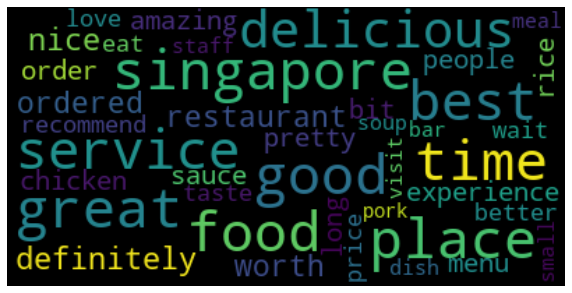

In [30]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
def plot_word_cloud(terms):
    text = terms.index
    text = ' '.join(list(text))
    # lower max_font_size
    wordcloud = WordCloud(max_font_size=40).generate(text)
    plt.figure(figsize=(10, 10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=True).head(40))

Check out the words with higher weightage.
We end up with less common words. These words naturally carry more meaning for the given review and may outline the underlying sentiment.

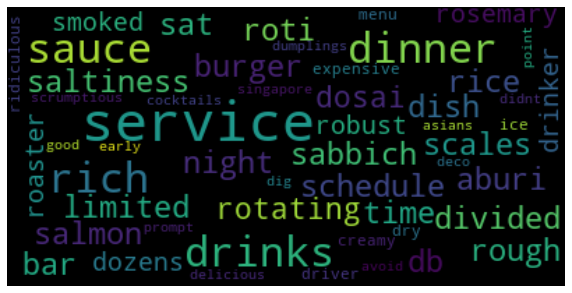

In [31]:
plot_word_cloud(tfidf.sort_values(by=['tfidf'], ascending=False).head(40))

For visualization purpose, I will make use of Bokeh.

Each dot is a review and the color encodes its sentiment.

By hovering on each review cluster, we can see groups of descriptions of similar keywords and thus referring to the same sentiment.

In [32]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=50, random_state=0)
svd_tfidf = svd.fit_transform(vz)

print(svd_tfidf.shape)

(1792, 50)


In [33]:
from sklearn.manifold import TSNE
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne_tfidf = tsne_model.fit_transform(svd_tfidf)
print(tsne_tfidf.shape)
tsne_tfidf_df = pd.DataFrame(tsne_tfidf)
tsne_tfidf_df.columns = ['x', 'y']
tsne_tfidf_df['category'] = res['Sentiment']
tsne_tfidf_df['description'] = res['Reviews']
tsne_tfidf_df.to_csv('/Users/ernestng/Desktop/projects/foodreview/tsid.csv', encoding='utf-8', index=False)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1792 samples in 0.003s...
[t-SNE] Computed neighbors for 1792 samples in 0.246s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1792
[t-SNE] Computed conditional probabilities for sample 1792 / 1792
[t-SNE] Mean sigma: 0.137183
[t-SNE] KL divergence after 250 iterations with early exaggeration: 74.515549
[t-SNE] KL divergence after 500 iterations: 1.214200
(1792, 2)


In [34]:
import bokeh.plotting as bp
from bokeh.models import HoverTool, BoxSelectTool
from bokeh.plotting import figure, show, output_notebook, reset_output
from bokeh.palettes import d3
import bokeh.models as bmo
from bokeh.io import save, output_file

output_notebook()
plot_tfidf = bp.figure(plot_width = 700, plot_height = 600, title = "TF-IDF Clustering of the reviews",
    tools = "pan,wheel_zoom,box_zoom,reset,hover,save",
    x_axis_type = None, y_axis_type = None, min_border = 1)

palette = d3['Category10'][len(tsne_tfidf_df['category'].unique()) + 1]
color_map = bmo.CategoricalColorMapper(factors = tsne_tfidf_df['category'].map(str).unique(), palette=palette)

plot_tfidf.scatter(x = 'x', y = 'y', color={'field': 'category', 'transform': color_map}, 
                   legend_group = 'category', source = tsne_tfidf_df)
hover = plot_tfidf.select(dict(type = HoverTool))
hover.tooltips = {"description": "@description", "category":"@category"}

show(plot_tfidf)

Loading BokehJS ...